<nav>
<a href="https://www.linkedin.com/in/jeshua-cespedes/">LinkedIn</a> |
<a href="https://github.com/jeshuacn">Github</a> |
<a href=”/js/”>Medium</a> |
</nav>

# Case Study: How Does a Bike-Share Navigate Speedy Success?

# **Summary**


## Scenario

The director of marketing believes the company’s future success depends on maximizing the number of annual memberships. Therefore, your team wants to understand how casual riders and annual members use bikes differently. From these insights, your team will design a new marketing strategy to convert casual riders into annual members.

## About Divvy
Divvy is Chicagoland’s bike share system across Chicago and Evanston. Divvy provides residents and visitors with a convenient, fun and affordable transportation option for getting around and exploring Chicago.

## Business Task:

Analyze and identify Divvy bikes used between annual members and casual riders for marketing strategy.


**Note:** any rider type different from member is considered casual

## The Data

The data is located on an AWS server where it is easily downloadable. It is organized by year and Fiscal Quarters.

In the following link you'll find Divvy's Historical trip data available for public use: [Public data](https://ride.divvybikes.com/system-data)

<ins>Each trip is anonymized and includes:</ins>

-Trip start day and time

-Trip end day and time

-Trip start station

-Trip end station

-Rider type (Member, Single Ride, and Day Pass)

The data has been processed to remove trips taken by staff as they service and inspect the system; and any trips below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it was secure).

**Note:** This data is provided according to the [Divvy Data License Agreement](https://ride.divvybikes.com/data-license-agreement) and released monthly.

# Data Preparation

In [1]:
# Importing useful libraries 

import requests
from bs4 import BeautifulSoup
import zipfile
import wget
import pandas as pd
import numpy as np
import os.path
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Loading the data

I will to load the last year of data for this analysis. To make it more fun and less tedious, I will use a parsing library to webscrap the webpage and download the data from the server where it is located to upload it later.


In [4]:
res = requests.get('https://divvy-tripdata.s3.amazonaws.com/')

soup = BeautifulSoup(res.text)
files = []
# iterating between all the content in the web-page
for a in soup.find_all('contents'):
# getting the name of the files in the key tag
    for j in a.find_all('key'):
      # Spliting the string and casting it to int to get only the year of the file in the name
      if int(j.text.split('-')[0].isnumeric()):
        # getting only the files after 2020-August
        if  int(j.text.split('-')[0]) >=202109:
          print(j.text)
          # adding the file name to the list variable
          files.append(j.text)

# I did it this way because I couldn't retrieve the <a> tag to get the href of the file in the index.html page where the data is stored.

202109-divvy-tripdata.zip

202110-divvy-tripdata.zip

202111-divvy-tripdata.zip

202112-divvy-tripdata.zip

202201-divvy-tripdata.zip

202202-divvy-tripdata.zip

202203-divvy-tripdata.zip

202204-divvy-tripdata.zip

202205-divvy-tripdata.zip

202206-divvy-tripdata.zip

202207-divvy-tripdata.zip

202208-divvy-tripdata.zip


As you can see, the data is inside a ZIP file, so we'll need to unzip the files :

In [5]:
# Creating data frame object
df = pd.DataFrame()

In [6]:
files[0].split('.')[0]

'202109-divvy-tripdata'

In [7]:
# we use the wget library to get the file from the URL and the zipfile library to unzip it.
from tqdm import tqdm

dfs = []
for i in tqdm(range(len(files))):
  file_folder = files[i].split('.')[0]
  # validating if we already downloaded the files
  if os.path.exists(files[i]) == False:
    response = wget.download('https://divvy-tripdata.s3.amazonaws.com/'+files[i],f'{files[i]}')
  
  # Validating if we already extrated the file
  if os.path.exists(f'data/{file_folder}') ==False:
    with zipfile.ZipFile(files[i], 'r') as zip_ref:
      
      zip_ref.extractall(f'data/{file_folder}')

  # Open the CSV file and append it to the data frame object to create the 
  # new data frame with all files
  with open('data/{}/{}.csv'.format( file_folder, file_folder)) as f:
    data = pd.read_csv(f)
    dfs.append(data)
  df = pd.concat(dfs,ignore_index=True)

df.head()

100%|██████████| 12/12 [00:24<00:00,  2.05s/it]


ride_id  rideable_type           started_at             ended_at  \
0  9DC7B962304CBFD8  electric_bike  2021-09-28 16:07:10  2021-09-28 16:09:54   
1  F930E2C6872D6B32  electric_bike  2021-09-28 14:24:51  2021-09-28 14:40:05   
2  6EF72137900BB910  electric_bike  2021-09-28 00:20:16  2021-09-28 00:23:57   
3  78D1DE133B3DBF55  electric_bike  2021-09-28 14:51:17  2021-09-28 15:00:06   
4  E03D4ACDCAEF6E00  electric_bike  2021-09-28 09:53:12  2021-09-28 10:03:44   

  start_station_name start_station_id end_station_name end_station_id  \
0                NaN              NaN              NaN            NaN   
1                NaN              NaN              NaN            NaN   
2                NaN              NaN              NaN            NaN   
3                NaN              NaN              NaN            NaN   
4                NaN              NaN              NaN            NaN   

   start_lat  start_lng  end_lat  end_lng member_casual  
0      41.89     -87.68    41.89   -87.67        casual  
1      41.94     -87.64    41.98   -87.67        casual  
2      41.81     -87.72    41.80   -87.72        casual  
3      41.80     -87.72    41.81   -87.72        casual  
4      41.88     -87.74    41.88   -87.71        casual

This process took us 24 seconds. Doing it this way, we saved a lot of time compared to if we had to download and unzip each file individually and then upload it to create the dataset.

## Data Transformation

Let's take a look to each column's data type

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5883043 entries, 0 to 5883042

Data columns (total 13 columns):

 #   Column              Dtype  

---  ------              -----  

 0   ride_id             object 

 1   rideable_type       object 

 2   started_at          object 

 3   ended_at            object 

 4   start_station_name  object 

 5   start_station_id    object 

 6   end_station_name    object 

 7   end_station_id      object 

 8   start_lat           float64

 9   start_lng           float64

 10  end_lat             float64

 11  end_lng             float64

 12  member_casual       object 

dtypes: float64(4), object(9)

memory usage: 583.5+ MB


In [9]:
# Casting the member_casual column to a category will store the data
# more efficiently, reducing the size of memory.
df['member_casual'] =  df['member_casual'].astype('category')

From the information above, we can see that `'started_at'` and 
`'ended_at'` are data type object instead of datetime, so we need to convert them to be able to do operations. 

In [10]:
# we use apply() and pd.to_datetime() function to convert multiple columns to DateTime.
df[['started_at','ended_at']]= df[['started_at','ended_at']].apply(pd.to_datetime)
df[['started_at','ended_at']].dtypes

started_at    datetime64[ns]
ended_at      datetime64[ns]
dtype: object

Now let's create a new variable that will contain the difference between the trip's end and start times.

In [11]:
df['ride_length'] = abs(df.ended_at-df.started_at)
df.ride_length.head()

0   0 days 00:02:44
1   0 days 00:15:14
2   0 days 00:03:41
3   0 days 00:08:49
4   0 days 00:10:32
Name: ride_length, dtype: timedelta64[ns]

Let's create other variables containing the day of the week, month, and year when the trip started.

**Note:** we are going to retrieve the day of the week, where Monday is 1 and Sunday is 7

In [12]:
def create_features(df):
  '''
  Args: 
    df (DataFrame): a DataFrame object

  Returns:
    DataFrame: DataFrame with new columns added
  '''
  df = df.copy() # avoid overwriting the DataFrame
  df['day_of_week'] = df.started_at.dt.dayofweek.astype('int8')+1
  df['day_of_week_name'] = df.started_at.dt.day_name()
  df['hour_of_day'] = df.started_at.dt.hour.astype('int8')
  df['year'] = df.started_at.dt.year.astype('int32')
  df['month_name'] = df.started_at.dt.month_name()
  df['month'] = df.started_at.dt.month.astype('int8')
  df['day'] = df.started_at.dt.day.astype('int8')

  return df

In [13]:
%%time
df = create_features(df)

CPU times: total: 3.59 s

Wall time: 3.59 s


Let's take a look at the new variables we created:

In [14]:
df[['started_at','day_of_week','day_of_week_name','hour_of_day','year','month_name','month','day']].head()

started_at  day_of_week day_of_week_name  hour_of_day  year  \
0 2021-09-28 16:07:10            2          Tuesday           16  2021   
1 2021-09-28 14:24:51            2          Tuesday           14  2021   
2 2021-09-28 00:20:16            2          Tuesday            0  2021   
3 2021-09-28 14:51:17            2          Tuesday           14  2021   
4 2021-09-28 09:53:12            2          Tuesday            9  2021   

  month_name  month  day  
0  September      9   28  
1  September      9   28  
2  September      9   28  
3  September      9   28  
4  September      9   28

## Data Cleaning

This analysis section will focus on detecting null values, duplicates and inconsistencies.

In [15]:
# Observe the columns with missing values and show the missing %
df.isna().mean()*100

ride_id                0.000000
rideable_type          0.000000
started_at             0.000000
ended_at               0.000000
start_station_name    15.032442
start_station_id      15.032408
end_station_name      16.085264
end_station_id        16.085264
start_lat              0.000000
start_lng              0.000000
end_lat                0.097348
end_lng                0.097348
member_casual          0.000000
ride_length            0.000000
day_of_week            0.000000
day_of_week_name       0.000000
hour_of_day            0.000000
year                   0.000000
month_name             0.000000
month                  0.000000
day                    0.000000
dtype: float64

As we can see in the code above, the columns `start_station_name`, `start_station_id`, `end_station_name`, `end_station_id`, `end_lat` and `end_lng` have missing data.

In [16]:
# I used the latitudes and longitudes in GoogleMaps to confirm that there was not a station and we can notice that
# this may be a common issue with the electric bikes
df[['start_lat','start_lng','end_lat','end_lng','rideable_type']].loc[df.start_station_name.isna()]

start_lat  start_lng  end_lat  end_lng  rideable_type
0            41.89     -87.68    41.89   -87.67  electric_bike
1            41.94     -87.64    41.98   -87.67  electric_bike
2            41.81     -87.72    41.80   -87.72  electric_bike
3            41.80     -87.72    41.81   -87.72  electric_bike
4            41.88     -87.74    41.88   -87.71  electric_bike
...            ...        ...      ...      ...            ...
5868384      41.94     -87.65    41.94   -87.65  electric_bike
5868385      41.93     -87.65    41.93   -87.65  electric_bike
5868386      41.79     -87.60    41.80   -87.59  electric_bike
5868387      41.96     -87.67    41.92   -87.68  electric_bike
5868388      41.90     -87.68    41.92   -87.70  electric_bike

[884365 rows x 5 columns]

In [36]:
# With this code, I can validate where the station name is Na because there is no station over there, so we can proceed to drop all Na values.
df.start_station_name.loc[(df.start_lat == 41.95)&(df.start_lng == -87.65) ]

2          NaN
18         NaN
381        NaN
417        NaN
515        NaN
          ... 
6672406    NaN
6672439    NaN
6672456    NaN
6672501    NaN
6672733    NaN
Name: start_station_name, Length: 11399, dtype: object

**GoogleMap image** for lat: 41.95 lng: -87.65:

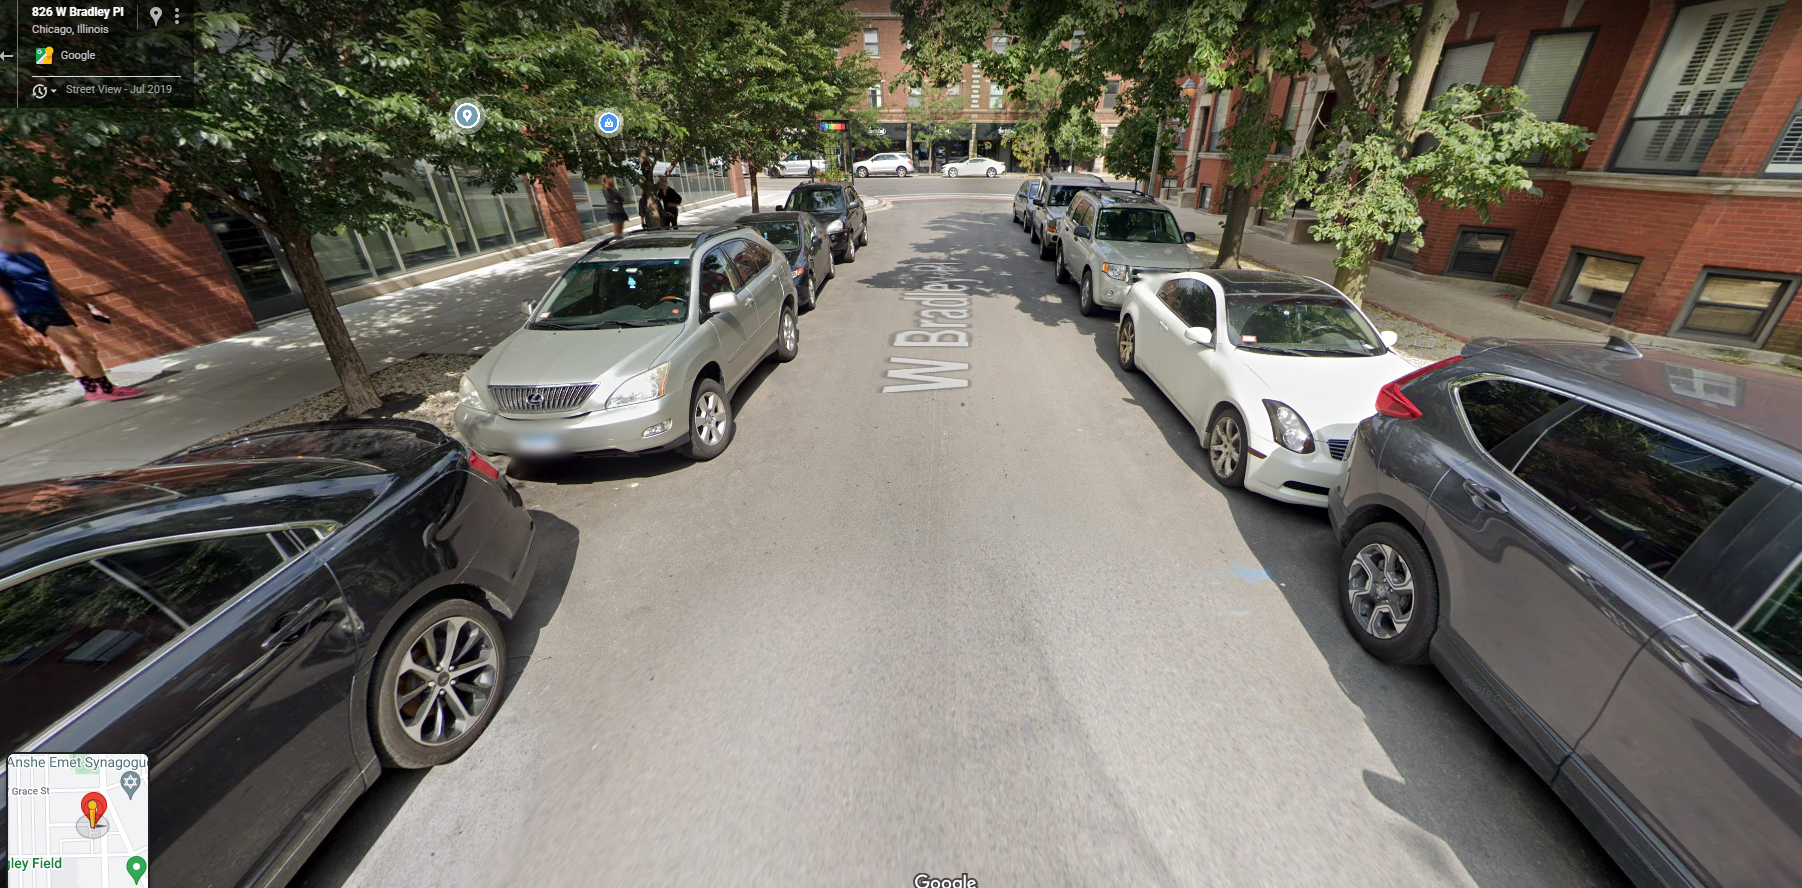

In [47]:
# Dropping start_lat, start_lng and end_lat, end_lng
clean_df = df.drop(['start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1) 

In [48]:
# Removing missing values
clean_df = clean_df.dropna()
print(clean_df.shape)
clean_df.head()

(4560146, 17)


ride_id rideable_type          started_at            ended_at  \
59   E92C804563F261EC  classic_bike 2021-09-05 01:25:08 2021-09-05 01:35:46   
61   9ECA91210441E847  classic_bike 2021-09-05 13:33:41 2021-09-05 14:06:08   
153  3DAA144C4E85E3AA  classic_bike 2021-09-04 23:00:21 2021-09-04 23:10:00   
180  53B99FE9BD0D35F8  classic_bike 2021-09-14 16:25:16 2021-09-14 16:35:03   
182  2DB60C25C8CE3591  classic_bike 2021-09-13 22:34:54 2021-09-13 22:34:58   

             start_station_name start_station_id           end_station_name  \
59         Wells St & Walton St     TA1306000011  Desplaines St & Kinzie St   
61   Larrabee St & Armitage Ave     TA1309000006      Clark St & Leland Ave   
153     Dearborn St & Monroe St     TA1305000006    Dearborn St & Monroe St   
180    Kingsbury St & Kinzie St     KA1503000043        Orleans St & Elm St   
182       Michigan Ave & Oak St            13042      Michigan Ave & Oak St   

    end_station_id member_casual     ride_length  day_of_week  \
59    TA1306000003        casual 0 days 00:10:38            7   
61    TA1309000014        casual 0 days 00:32:27            7   
153   TA1305000006        casual 0 days 00:09:39            6   
180   TA1306000006        casual 0 days 00:09:47            2   
182          13042        casual 0 days 00:00:04            1   

    day_of_week_name  hour_of_day  year month_name  month  day  
59            Sunday            1  2021  September      9    5  
61            Sunday           13  2021  September      9    5  
153         Saturday           23  2021  September      9    4  
180          Tuesday           16  2021  September      9   14  
182           Monday           22  2021  September      9   13

In [203]:
clean_df.min()

ride_id                       00000123F60251E6
rideable_type                     classic_bike
started_at                 2021-09-01 00:00:06
ended_at                   2021-09-01 00:03:37
start_station_name    10101 S Stony Island Ave
start_station_id                        021320
end_station_name      10101 S Stony Island Ave
end_station_id                          021320
ride_length                    0 days 00:00:01
day_of_week                                  1
day_of_week_name                        Friday
hour_of_day                                  0
year                                      2021
month_name                               April
month                                        1
day                                          1
dtype: object

From the above results, we can notice that the min value for ride_length is 0 days 00:00:00. This is incorrect because every ride length should be greater than 0.

**Removing rows with ride length < 0 days 00:00:00**

In [49]:
clean_df = clean_df[clean_df['ride_length'] > '00:00:00']

Also, we could notice that there were some observations where the hour of the day was 0; this is because these trips started at midnight.

In [50]:
clean_df.loc[df.hour_of_day ==0].head(3)

ride_id rideable_type          started_at            ended_at  \
1135  8293F229A2ACFC09  classic_bike 2021-09-12 00:26:45 2021-09-12 00:55:52   
2665  AA58BAE5C423FF3D  classic_bike 2021-09-12 00:06:44 2021-09-12 00:21:17   
2692  EEAC7865EEC03D0C   docked_bike 2021-09-11 00:30:29 2021-09-11 01:15:24   

               start_station_name start_station_id  \
1135        Michigan Ave & Oak St            13042   
2665        Clark St & Newport St              632   
2692  Michigan Ave & Jackson Blvd     TA1309000002   

                       end_station_name end_station_id member_casual  \
1135              Michigan Ave & Oak St          13042        casual   
2665       Ashland Ave & Wrightwood Ave          13296        casual   
2692  DuSable Lake Shore Dr & Monroe St          13300        casual   

         ride_length  day_of_week day_of_week_name  hour_of_day  year  \
1135 0 days 00:29:07            7           Sunday            0  2021   
2665 0 days 00:14:33            7           Sunday            0  2021   
2692 0 days 00:44:55            6         Saturday            0  2021   

     month_name  month  day  
1135  September      9   12  
2665  September      9   12  
2692  September      9   11

### Checking for duplicates

We use the ride_id column to check for duplicates because each ride should be unique in the dataset.

In [51]:
clean_df.ride_id.duplicated().sum()

0

As we can see in the code above, there's no duplicated ride in the dataset.

### Standardizing station names

Making sure every start and end station names are in the title case.


In [52]:
# start_station_name
clean_df.start_station_name = clean_df.loc[:,'start_station_name'].apply(str.title)
# end_station_name
clean_df.end_station_name = clean_df.loc[:,'end_station_name'].apply(str.title)

In [55]:
# Saving our cleaned data
clean_df.to_pickle('Cyclistic_clean_data_2021-09_to_2022-08.pkl')

In [2]:
# Loading clean data in the case that needed
#clean_df = pd.read_pickle('Cyclistic_clean_data_2021-09_to_2022-08.pkl')

# Exploratory Data Analysis

In [56]:
clean_df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'member_casual', 'ride_length', 'day_of_week',
       'day_of_week_name', 'hour_of_day', 'year', 'month_name', 'month',
       'day'],
      dtype='object')

In [57]:
clean_df.describe()

ride_length   day_of_week   hour_of_day          year  \
count                    4559954  4.559954e+06  4.559954e+06  4.559954e+06   
mean   0 days 00:18:00.037280858  4.086344e+00  1.421494e+01  2.021664e+03   
std    0 days 01:15:22.975918701  1.991303e+00  4.976968e+00  4.722802e-01   
min              0 days 00:00:01  1.000000e+00  0.000000e+00  2.021000e+03   
25%              0 days 00:06:17  2.000000e+00  1.100000e+01  2.021000e+03   
50%              0 days 00:11:00  4.000000e+00  1.500000e+01  2.022000e+03   
75%              0 days 00:19:45  6.000000e+00  1.800000e+01  2.022000e+03   
max             28 days 06:25:01  7.000000e+00  2.300000e+01  2.022000e+03   

              month           day  
count  4.559954e+06  4.559954e+06  
mean   7.209082e+00  1.569571e+01  
std    2.536963e+00  8.709511e+00  
min    1.000000e+00  1.000000e+00  
25%    5.000000e+00  9.000000e+00  
50%    7.000000e+00  1.600000e+01  
75%    9.000000e+00  2.300000e+01  
max    1.200000e+01  3.100000e+01

The average ride length is 18 minutes.

In [58]:
clean_df.describe(exclude = 'number')

C:\Users\Jeshua Cespedes\AppData\Local\Temp\ipykernel_13836\3789540179.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

  clean_df.describe(exclude = 'number')

C:\Users\Jeshua Cespedes\AppData\Local\Temp\ipykernel_13836\3789540179.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

  clean_df.describe(exclude = 'number')


ride_id rideable_type           started_at  \
count            4559954       4559954              4559954   
unique           4559954             3              3928397   
top     E92C804563F261EC  classic_bike  2022-07-09 17:23:31   
freq                   1       2890715                    8   
first                NaN           NaN  2021-09-01 00:00:06   
last                 NaN           NaN  2022-08-31 23:58:50   

                   ended_at       start_station_name start_station_id  \
count               4559954                  4559954          4559954   
unique              3936091                     1365             1220   
top     2022-06-22 08:01:59  Streeter Dr & Grand Ave            13022   
freq                     14                    74659            74659   
first   2021-09-01 00:03:37                      NaN              NaN   
last    2022-09-01 19:10:49                      NaN              NaN   

               end_station_name end_station_id member_casual day_of_week_name  \
count                   4559954        4559954       4559954          4559954   
unique                     1395           1237             2                7   
top     Streeter Dr & Grand Ave          13022        member         Saturday   
freq                      76178          76178       2682048           752888   
first                       NaN            NaN           NaN              NaN   
last                        NaN            NaN           NaN              NaN   

       month_name  
count     4559954  
unique         12  
top          July  
freq       642643  
first         NaN  
last          NaN

The most common bike type used is the classic, the most used station is the Streeter Dr. & Grand Ave, the most popular day of the week to go for a ride are Saturdays and the most popular month is July.

## Proportion of User Type

In [242]:
# Grouping by user type
user_proportion = clean_df.groupby('member_casual').size().reset_index(name = 'count')

# Getting the proportion of user type
user_proportion['proportion'] = (user_proportion['count']/ user_proportion['count'].sum())*100

In [243]:
user_proportion

member_casual    count  proportion
0        casual  1877906   41.182565
1        member  2682048   58.817435

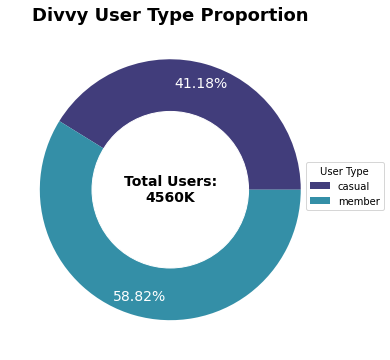

In [317]:
fig, ax = plt.subplots(figsize = (15,6))

# Pie chart
plt.pie(user_proportion.proportion,
        autopct='%1.2f%%',
        pctdistance=0.85,
        colors =['#413d7b','#348fa7'],
        textprops={'fontsize':14,'color':'w'})

# Drawing circle to create a donnut chart
my_circle=plt.Circle( (0,0), 0.6, color='white')
p=plt.gcf()

# Adding circle in Pie chart
p.gca().add_artist(my_circle)

# Adding title
plt.title('Divvy User Type Proportion',
        fontdict={'fontweight':'bold','fontsize':18})

# Adding text in the middle
ax.text(0., 0.,'Total Users:\n{:0.0f}K'.format(user_proportion['count'].sum()/1000), 
        horizontalalignment='center',
        verticalalignment='center',
        fontdict={'fontweight':'bold','fontsize':14})
        
# Adding legend        
plt.legend(['casual','member'],title='User Type', bbox_to_anchor=(0.9, 0.6))
fig.set_facecolor('w')
plt.show()


## Average Ride Length by User Type

In [59]:
# Average ride_length for members and casual riders
av_ride_length_by_user = clean_df.groupby('member_casual',as_index = False)['ride_length'].mean()\
  .rename(columns={'ride_length':'average_ride_length'})
av_ride_length_by_user

member_casual       average_ride_length
0        casual 0 days 00:25:47.407986874
1        member 0 days 00:12:32.795466747

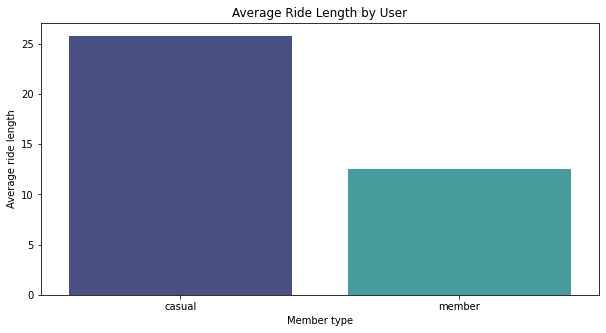

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x = av_ride_length_by_user.member_casual, 
            y = av_ride_length_by_user.average_ride_length.dt.total_seconds()/60,
            ax =ax,
            palette='mako')\
  .set(title='Average Ride Length by User', xlabel = 'Member type',
       ylabel = 'Average ride length')
plt.show()

On average, casual users have loger ride trips in comparison with member users.

## Average ride length by user type and by day of the week

In [61]:
# Average ride_length for users by day_of_week
av_ride_length_by_user_and_day = clean_df.groupby(['member_casual','day_of_week_name'],as_index = False)['ride_length'].mean()\
  .rename(columns ={'ride_length':'average_ride_length'})

# Sorting the output by the sorter list.
sorter = ['casual','member','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
av_ride_length_by_user_and_day.sort_values(by=["member_casual","day_of_week_name"], 
                                           key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
av_ride_length_by_user_and_day

member_casual day_of_week_name       average_ride_length
1         casual           Monday 0 days 00:26:46.657052644
5         casual          Tuesday 0 days 00:22:34.463801400
6         casual        Wednesday 0 days 00:22:04.992217324
4         casual         Thursday 0 days 00:22:46.477447873
0         casual           Friday 0 days 00:24:01.843746002
2         casual         Saturday 0 days 00:28:23.375437451
3         casual           Sunday 0 days 00:29:43.455147975
8         member           Monday 0 days 00:12:09.608896100
12        member          Tuesday 0 days 00:11:48.799135117
13        member        Wednesday 0 days 00:11:55.219022446
11        member         Thursday 0 days 00:12:02.566633976
7         member           Friday 0 days 00:12:16.118723833
9         member         Saturday 0 days 00:14:05.253446779
10        member           Sunday 0 days 00:14:08.189322414

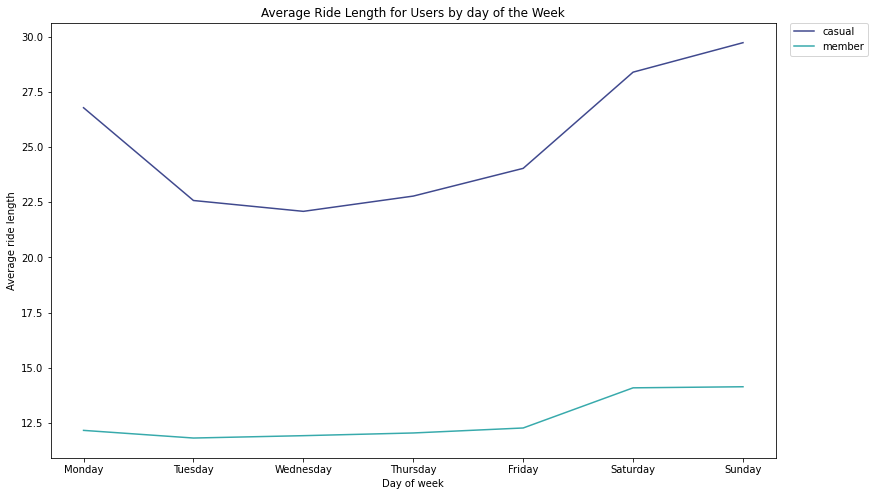

In [62]:
fig, ax = plt.subplots(figsize=(13, 6))

sns.lineplot(x = "day_of_week_name",y = av_ride_length_by_user_and_day.average_ride_length.dt.total_seconds()/60,
            data =av_ride_length_by_user_and_day, 
            hue = "member_casual",ax=ax,
            palette = "mako")\
            .set(xlabel="Day of week", ylabel = "Average ride length")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Average Ride Length for Users by day of the Week")
plt.show()

The graph above shows that users tend to have longer rides on weekends, especially casual users.

## Number of Rides for Users by Day of the Week

In [63]:
# Number of rides for users by day_of_week
number_user_rides_by_day=clean_df.groupby(['member_casual','day_of_week_name'],
                                    as_index = False)['ride_id'].count()\
  .rename(columns ={'ride_id':'number_of_rides'})

# Sorting the output by the sorter list.
number_user_rides_by_day.sort_values(by=["member_casual","day_of_week_name"], 
                                           key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
number_user_rides_by_day

member_casual day_of_week_name  number_of_rides
1         casual           Monday           221066
5         casual          Tuesday           205519
6         casual        Wednesday           216892
4         casual         Thursday           230976
0         casual           Friday           257971
2         casual         Saturday           401473
3         casual           Sunday           344009
8         member           Monday           376547
12        member          Tuesday           426879
13        member        Wednesday           434718
11        member         Thursday           412965
7         member           Friday           365689
9         member         Saturday           351415
10        member           Sunday           313835

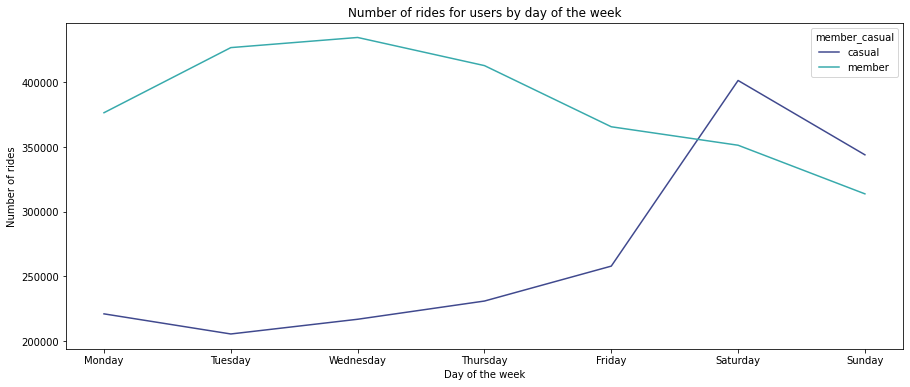

In [64]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = 'day_of_week_name',
             y = 'number_of_rides',
             data = number_user_rides_by_day,
             hue ='member_casual',ax=ax,
             palette = 'mako')\
             .set(title='Number of rides for users by day of the week',
                  xlabel = 'Day of the week',
                  ylabel = 'Number of rides')

plt.show()

In the graph above, we can see clearly that casual users ride on weekends and member users on weekdays.

## Type of Bike used by User Type

In [65]:
# User ride by Bike type used by user type.
user_rides_by_bike_type = clean_df.groupby(['member_casual','rideable_type'])\
  .size().reset_index(name = 'counts')

user_rides_by_bike_type

member_casual  rideable_type   counts
0        casual   classic_bike  1027978
1        casual    docked_bike   205771
2        casual  electric_bike   644157
3        member   classic_bike  1862737
4        member    docked_bike        0
5        member  electric_bike   819311

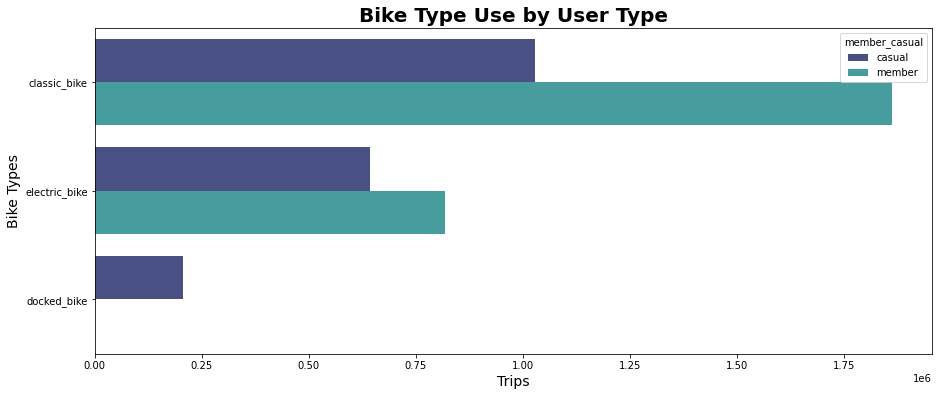

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(y = 'rideable_type', data = clean_df,
              hue = 'member_casual',palette = 'mako',ax = ax)

# Setting the Title
ax.set_title('Bike Type Use by User Type', fontdict={'fontweight':'bold','fontsize':20})

# Setting the Ylabel
ax.set_ylabel('Bike Types', fontsize = 14)

# Setting the Xlabe;
ax.set_xlabel('Trips', fontsize = 14)
plt.show()

The most popular bikes among user types are the classic bikes, followed by the electric ones.

## Distribution of Rides per Hour

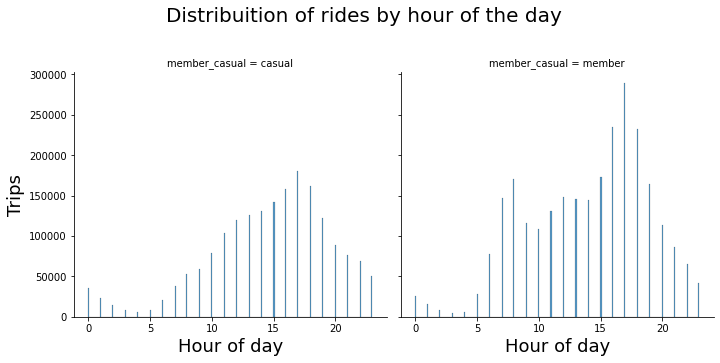

In [5]:
# Distribution of rides by hour.
g =sns.displot(clean_df, 
               x="hour_of_day", 
               col="member_casual")

# Setting title
g.figure.subplots_adjust(top=0.8)
g.fig.suptitle('Distribuition of rides by hour of the day',fontsize=20,
    fontdict={'weight': 'bold'}) 

# Setting X labels
g.set_xlabels('Hour of day',fontsize = 18)

# Setting Y labels
g.set_ylabels('Trips', fontsize = 18)

Here we can see some outliers on both groups of users between 12:00 A.M. and 4:00 A.M.

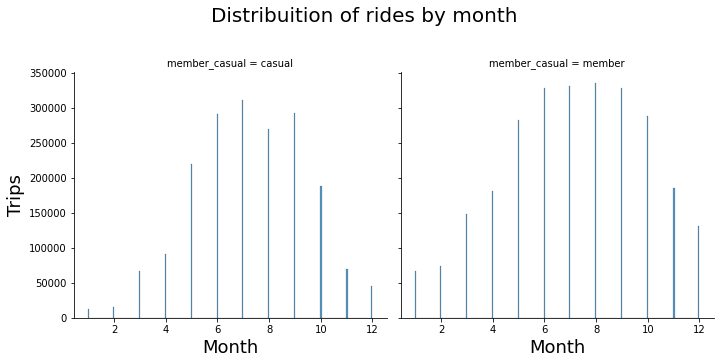

In [4]:
# Distplot for rides by month per user type
g =sns.displot(clean_df, 
               x="month", 
               col="member_casual")
# Setting title
g.figure.subplots_adjust(top=0.8)
g.fig.suptitle('Distribuition of rides by month',fontsize=20,
    fontdict={'weight': 'bold'}) 

# Setting X labels
g.set_xlabels('Month',fontsize = 18)

# Setting Y labels
g.set_ylabels('Trips', fontsize = 18)

## Number of Trips by Month

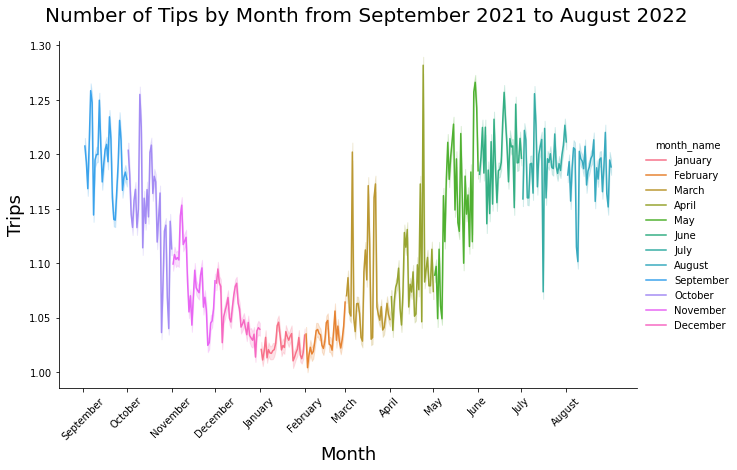

In [340]:
# Grouping by month_name and started_at date and getting number of trips
user_rides_per_month = clean_df.groupby(['month_name','started_at'])\
  .size().reset_index(name = 'counts')

# Creating plot
g = sns.relplot(x = user_rides_per_month.started_at.dt.date,
            y = 'counts',
            data = user_rides_per_month,
            hue= 'month_name',
            kind ='line',
            height=6,
            aspect=1.5,
            hue_order=['January','February','March','April','May','June','July','August','September','October','November','December'])

# Changing the number of Xticks displayed
g.set(xticks=pd.date_range(start = '8/1/2021', periods = 12, freq = 'M'))

g.figure.subplots_adjust(top=0.9)

# Setting the tittle
g.figure.suptitle(
    'Number of Tips by Month from September 2021 to August 2022',
    fontsize=20,
    fontdict={"weight": "bold"}
)
# Setting X labels
g.set_xlabels('Month',fontsize = 18)

# Setting Y labels
g.set_ylabels('Trips', fontsize = 18)

# Changing Xticks labels to month names
g.set_xticklabels(['September','October','November','December','January','February','March','April','May','June','July','August'],
                  rotation = 45)


## Number of Trips by Month per User Type 

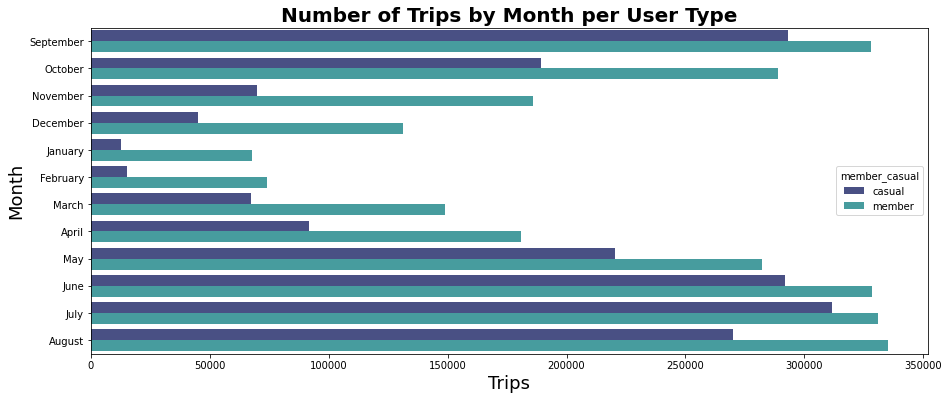

In [325]:
fig, ax = plt.subplots(figsize = (15,6))
sns.countplot(y = 'month_name',
              data = clean_df,
              hue = 'member_casual',
              palette = 'mako', 
              ax = ax)

ax.set_title('Number of Trips by Month per User Type',fontdict = {'fontweight':'bold','fontsize':20})
ax.set_ylabel('Month',fontsize = 18)
ax.set_xlabel('Trips', fontsize =18)
plt.show()

### Correlation between Month and Ride Length

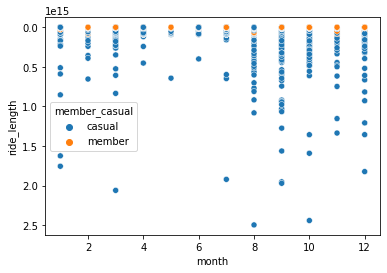

In [ ]:
# relationship between month and ride length
sns.scatterplot(x = 'month',y ='ride_length', data = clean_df,hue ='member_casual')

There is not any linear relationship between the month of the year and the ride length by user.

## Top 30 stations for casual riders

In [205]:
# Filtering DataFrame for member type = Casual and creating new DataFrame
casual = clean_df.loc[clean_df.member_casual == 'casual']

# Creating a new column with the start station name and end station name joined together
casual['station'] = casual.start_station_name+"-"+casual.end_station_name 

# Creating a new column to store if the start and end station names are the same
casual['same_start_and_end_station'] = ['Yes' if casual.start_station_name[x] == casual.end_station_name[x] else 'No' for x in casual.index]

# Group by station and same_start_and_end_station
group_casual = casual.groupby(['station','same_start_and_end_station'])\
    .size().reset_index(name = 'counts')\
    .sort_values(by = 'counts',ascending = False)[:30] # Here we sort the values in descending order and filter only the top 30.

# Printing first 5 observations
group_casual.head(5)

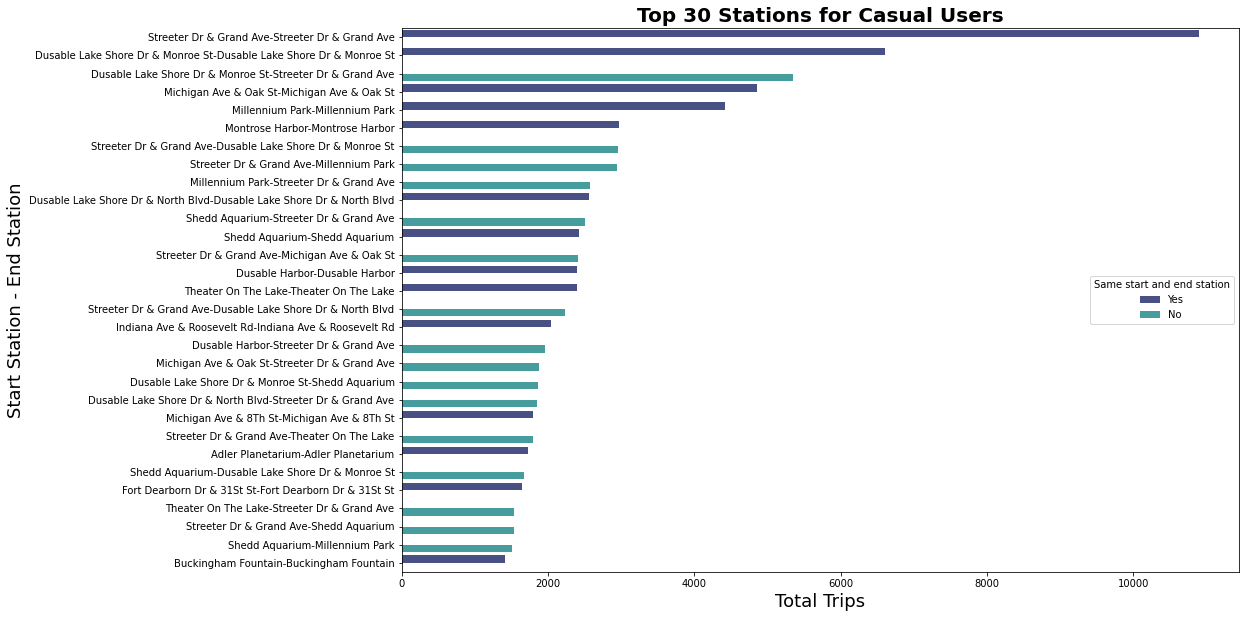

In [218]:
# Creating Bar Chart
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x= 'counts',
            y = 'station',
            data = group_casual,
            hue = 'same_start_and_end_station',
            palette='mako',
            ax = ax)
# Setting the tittle          
ax.set_title('Top 30 Stations for Casual Users',fontdict = {'fontweight':'bold','fontsize':20})

# Setting the Xlabel
ax.set_xlabel('Total Trips', fontsize = 18)

# Setting the Ylabel
ax.set_ylabel('Start Station - End Station',fontsize = 18)

# Adjusting legend
plt.legend(loc = 'center right',title='Same start and end station')

Here we can notice that Casual users start and end their trips at the same station. This might be an explanation for why their ride lengths are more extended than Member users.

## Top 30 stations for Member riders

In [214]:
# Filtering DataFrame for member type = Member and creating new DataFrame
member = clean_df.loc[clean_df.member_casual == 'member']

# Creating a new column with the start station name and end station name joined together
member['station'] = member.start_station_name+"-"+member.end_station_name 

# Creating a new column to store if the start and end station names are the same
member['same_start_and_end_station'] = ['Yes' if member.start_station_name[x] == member.end_station_name[x] else 'No' for x in member.index]

# Group by station and same_start_and_end_station
group_member = member.groupby(['station','same_start_and_end_station'])\
    .size().reset_index(name = 'counts')\
    .sort_values(by = 'counts',ascending = False)[:30] # Here we sort the values in descending order and filter only the top 30.

# Printing first 5 observations
group_member.head(5)

station  \
47872   Ellis Ave & 60Th St-University Ave & 57Th St   
121808  University Ave & 57Th St-Ellis Ave & 60Th St   
47811        Ellis Ave & 60Th St-Ellis Ave & 55Th St   
47608        Ellis Ave & 55Th St-Ellis Ave & 60Th St   
16469       Calumet Ave & 33Rd St-State St & 33Rd St   

       same_start_and_end_station  counts  
47872                          No    5681  
121808                         No    5515  
47811                          No    5352  
47608                          No    4710  
16469                          No    2642

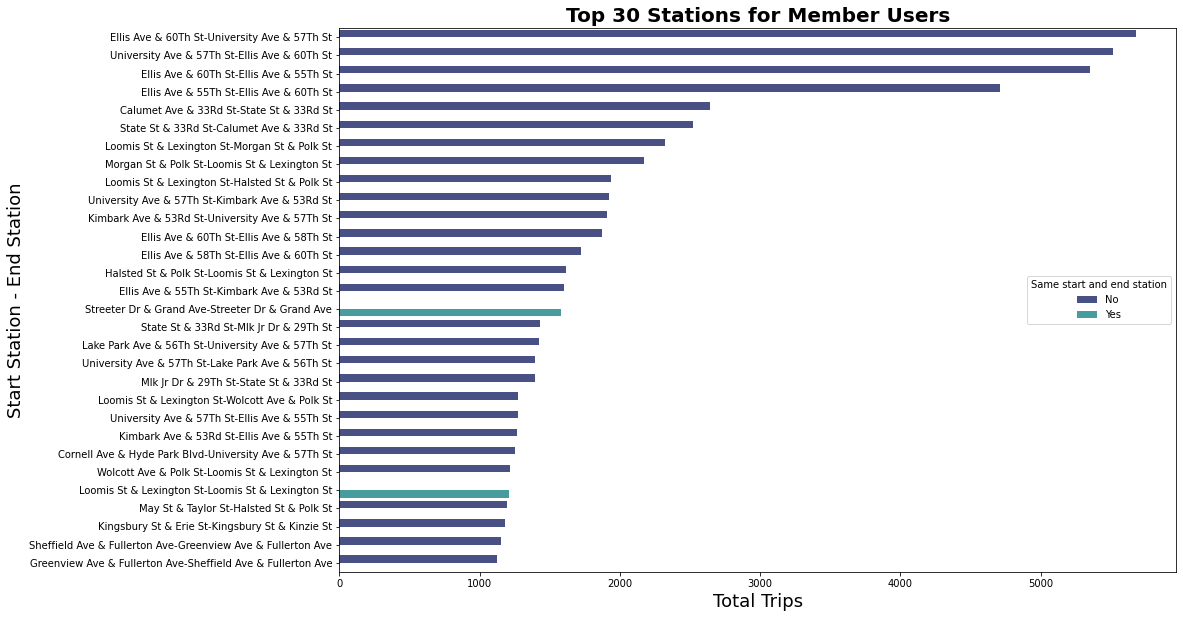

In [217]:
# Creating Bar Chart
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x= 'counts',
            y = 'station',
            data = group_member,
            hue = 'same_start_and_end_station',
            palette='mako',
            ax = ax)

# Setting the title
ax.set_title('Top 30 Stations for Member Users',fontdict = {'fontweight':'bold','fontsize':20})

# Setting Xlabel
ax.set_xlabel('Total Trips', fontsize = 18)

# Setting Ylabel
ax.set_ylabel('Start Station - End Station',fontsize = 18)

# Adjusting legend
plt.legend(loc = 'center right',title='Same start and end station')

Approximately 93% of member users' trips start and end at different stations. This probably is because Member users mainly use the bikes on weekdays, posibily to commute to work.

# Conclusions

### Insights

* 58.82% of users are Member users
* Casual users use the services mainly on weekends.
* Member users use the services mainly on weekdays. 
* Casual users' ride length is longer than Member users' type. This is probably because casual users start and end their trips at the same station.
* On average both user types have longer trips on weekends.
* The most common bike among both user types is the Classic bike, followed by the Electric bike.
* The preferred time for a ride is between May and September.

# Recommendations

Since Casual users are a substantial proportion of users that uses our services,41.18%, we should consider the following recommendations:

- Create a promotion where casual rides can subscribe for unlimited rides on weekends.
- Create a promotional strategy to target Casual users that use our bikes to commute to work
- As Casual users tend to have longer ride lengths, we should aim to show Casual users the benefits of annual memberships.